<img src='files/thresher.png' width=300 align='left'>

# Evann Smith, Ph.D.

<b>Senior Data Scientist</b> <br />
evann@thresher.io <br />
http://www.evannsmith.com

# Modeling Text Data

## Unsupervised vs. Supervised Learning

### Unsupervised
We have NO training data.

- Exploration
- Discovery
- Data Mining
- Hypothesis Generation

### Supervised
We have training data! <br />
<b>Thresher</b> can get you there quickly :)

- Answering a specific question
- Hypothesis testing
- Prediction

In [1]:
import gzip
import numpy as np
import pandas as pd
import random
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
from gensim import corpora, models
from sklearn import cross_validation
from tabulate import tabulate
import pyLDAvis.gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn import svm

## Data

### Download the data
- https://snap.stanford.edu/data/web-Amazon.html <br />
- We are using a subset of Amazon Instant Video Reviews

In [2]:
%%bash
wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz

--2017-05-17 10:50:37--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz
Resolving snap.stanford.edu... 171.64.75.80
Connecting to snap.stanford.edu|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9517526 (9.1M) [application/x-gzip]
Saving to: ‘reviews_Amazon_Instant_Video_5.json.gz’

     0K .......... .......... .......... .......... ..........  0%  216K 43s
    50K .......... .......... .......... .......... ..........  1%  598K 29s
   100K .......... .......... .......... .......... ..........  1%  333K 28s
   150K .......... .......... .......... .......... ..........  2%  523K 26s
   200K .......... .......... .......... .......... ..........  2%  639K 23s
   250K .......... .......... .......... .......... ..........  3%  848K 21s
   300K .......... .......... .......... .......... ..........  3%  655K 20s
   350K .......... .......... .......... .......... ..........  4% 1.84M 18s
   40

### Read the data
- Parsing code: http://jmcauley.ucsd.edu/data/amazon/

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

data = getDF('reviews_Amazon_Instant_Video_5.json.gz')

- Keep only the overall rating column and the text column <br />
- Map rating to an integer<br />
- Remove rows with null values

In [4]:
data = data[['overall', 'reviewText']]
data = data.dropna()
data['overall'] = data['overall'].map(int)
print('{} reviews'.format(len(data)))
data.head()

37126 reviews


,overall,reviewText
0,2,I had big expectations because I love English ...
1,5,I highly recommend this series. It is a must f...
2,1,This one is a real snoozer. Don't believe anyt...
3,4,Mysteries are interesting. The tension betwee...
4,5,"This show always is excellent, as far as briti..."


### Preprocess the Data
- Lowercase
- Tokenize
- Remove stop words and punctuation
- Remove words with fewer than 2 characters
- Stem

In [5]:
stop = set(stopwords.words('english') + list(string.punctuation))
stemmer = PorterStemmer()
re_punct = re.compile('[' + ''.join(string.punctuation) + ']')

In [6]:
def preprocess(text):
    try:
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if not t in stop]
        tokens = [re.sub(re_punct, '', t) for t in tokens]
        tokens = [t for t in tokens if len(t) > 2]
        tokens = [stemmer.stem(t) for t in tokens]
        if len(tokens) == 0:
            return None
        else:
            return ' '.join(tokens)
    except:
        return None

In [7]:
data['tokens'] = data['reviewText'].progress_map(preprocess)
data = data[data['tokens'].notnull()]
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

progress-bar: 100%|██████████| 37126/37126 [00:54<00:00, 675.76it/s]


In [8]:
print('{} reviews'.format(len(data)))
data.head()

37123 reviews


,overall,reviewText,tokens
0,2,I had big expectations because I love English ...,big expect love english particular investig de...
1,5,I highly recommend this series. It is a must f...,highli recommend seri must anyon yearn watch g...
2,1,This one is a real snoozer. Don't believe anyt...,one real snoozer believ anyth read hear aw ide...
3,4,Mysteries are interesting. The tension betwee...,mysteri interest tension robson tall blond goo...
4,5,"This show always is excellent, as far as briti...",show alway excel far british crime mysteri sho...


### Build a dictionary and construct a corpus

In [9]:
texts = [tokens.split() for tokens in data.tokens]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

In [10]:
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]


In [11]:
corpora.MmCorpus.serialize('reviews.mm', corpus)
id2word.save('reviews.dict')

## Unsupervised Analysis for Discovery

### Latent Dirichlet Allocation (LDA)

- Generative statistical model 
- Expains similarlites between observations as function of unobserved groups

<br />

For text data:
- Documents are a mixture of topics
    - Topics are assumed to have a sparse Dirichlet prior (capturing the intuition that documents only cover a few topics and topics only use a small set of words frequently)
- Topics are a distribution of words

<br />

Topics are <b>latent structures</b>, which we try to backwards infer from the collection of documents that could have generated them:
- Decide the length of the document, N
- Choose a topic mixture (e.g., 1/3 about zombies and 2/3 about romance) from a Dirichlet distribution with K fixed topics
- Generate each word in the document by:
    - Pick a topic according to the distribution sampled above
    - Pick a word according to the topic's distribution of words

<br />

To learn the topics and words (collapsed Gibbs Sampling):
- Randomly assign each word in each document to a topic K
    - This gives you (bad) topic representations of all documents and word distributions of all topics
- Improve for each word in each document by:
    - Assuming that all topic assignments except for the current word are correct and update the assignment of the current word using the generative model
    - Rinse, repeat until you reach a "steady state"

### Cross-Validated LDA
The existential question: <b>How many topics?</b>

- Theoretical validation
    - No substitute for substantive expertise
- Empirical validation on held-out data
    - We want to minimize perplexity, which is a decreasing function of the log-likelihood on unseen documents. (The higher the log-liklihood on unseen documents, the better the model.)

<b>CAVEAT 1:</b> The statistically optimal empirical solution may not be the theoretically optimal solution. Estimating the optimal mixture of distributions is not the same thing as estimating the number of "cohesive and well-separated from other data" ideas (Baudry et al. 2010; also see Biernacki, 2000). <br />
<br />
<b>CAVEAT 2:</b> Perplexity is not strongly correlated with human judgement (Chang et al., 2009).

In [12]:
def ldaCV(n_topics, corpus, id2word, test_size=0.2, sample=None):
    if not isinstance(n_topics, list):
        n_topics = [n_topics]
    obs = len(corpus)
    corpus = np.array(corpus)
    
    if sample is not None:
        if sample < 1:
            sample_idx = random.sample(range(obs), int(obs*sample))
        else:
            sample_idx = random.sample(range(obs), int(sample))
        corpus = corpus[sample_idx]
    
    train, test = cross_validation.train_test_split(corpus, test_size=test_size)
    perplexities = []
    
    for n in n_topics:
        print('{} topics'.format(n))
        model = models.ldamodel.LdaModel(train, num_topics=n, id2word=id2word)
        perplexity = model.log_perplexity(test)       
        print(' - Perplexity: {}'.format(round(perplexity, 3)))
        perplexities.append((n, perplexity))
    
    return perplexities    

In [13]:
%time p = ldaCV(list(range(40, 220, 20)), corpus, id2word)

40 topics
 - Perplexity: -10.757
60 topics
 - Perplexity: -11.769
80 topics
 - Perplexity: -12.704
100 topics
 - Perplexity: -13.608
120 topics
 - Perplexity: -14.498
140 topics
 - Perplexity: -15.364
160 topics
 - Perplexity: -16.194
180 topics
 - Perplexity: -17.029
200 topics
 - Perplexity: -17.833
CPU times: user 28min 19s, sys: 36.5 s, total: 28min 56s
Wall time: 29min 50s


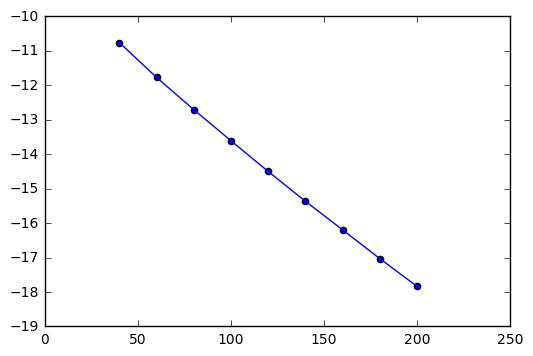

In [14]:
x, y = zip(*p)
plt.plot(x, y)
plt.scatter(x, y)
plt.show()

### Full Model

In [15]:
model = models.ldamodel.LdaModel(corpus, num_topics=200, id2word=id2word)

In [16]:
model.save('reviews_200_lda.model')

### View Top Topic Words
- View the top 5 words associated with 10 random topics.
- The number is the weight of the word it is multiplying (i.e., how much does this word influence the particular topic). 

In [17]:
model.print_topics(num_topics=10, num_words=5)

[(3,
  '0.070*"castl" + 0.040*"bone" + 0.035*"wind" + 0.033*"excess" + 0.026*"kiss"'),
 (81,
  '0.042*"project" + 0.039*"rais" + 0.022*"wolf" + 0.019*"lesbian" + 0.017*"redempt"'),
 (172,
  '0.124*"jack" + 0.071*"jane" + 0.033*"gain" + 0.021*"weight" + 0.019*"health"'),
 (135,
  '0.050*"audienc" + 0.049*"ridicul" + 0.039*"lack" + 0.027*"earlier" + 0.020*"demand"'),
 (155,
  '0.071*"wast" + 0.055*"time" + 0.050*"money" + 0.046*"annoy" + 0.035*"romanc"'),
 (199,
  '0.037*"tale" + 0.034*"ebert" + 0.028*"success" + 0.023*"obviou" + 0.017*"ground"'),
 (100,
  '0.073*"avail" + 0.067*"wish" + 0.067*"came" + 0.045*"fire" + 0.038*"current"'),
 (23,
  '0.065*"stephen" + 0.049*"cult" + 0.035*"student" + 0.030*"senat" + 0.029*"insid"'),
 (184,
  '0.213*"mysteri" + 0.059*"depress" + 0.044*"murder" + 0.026*"credibl" + 0.025*"irish"'),
 (162,
  '0.101*"side" + 0.096*"8230" + 0.049*"local" + 0.040*"suggest" + 0.029*"station"')]

### Query the Model
- Credit to http://christop.club/2014/05/06/using-gensim-for-lda/

In [18]:
query = "There are no monsters under the bed, just dust bunnies. It's not scary at all."
query = preprocess(query).split()

In [19]:
new_id2word = corpora.Dictionary()
_ = new_id2word.merge_with(id2word) # this doesn't return us anything of use right now

In [20]:
query = new_id2word.doc2bow(query)
print(query)

[(2822, 1), (7919, 1), (14837, 1), (24531, 1), (27488, 1)]


In [21]:
topic_relevance = list(sorted(model[query], key=lambda x: -x[1]))
print('Most relevant: {}'.format(topic_relevance[0]))
print('Least relevant: {}'.format(topic_relevance[-1]))

Most relevant: (199, 0.16750575643869006)
Least relevant: (108, 0.16749424356131073)


In [22]:
model.print_topic(topic_relevance[0][0]) # most related

'0.037*"tale" + 0.034*"ebert" + 0.028*"success" + 0.023*"obviou" + 0.017*"ground" + 0.015*"one" + 0.013*"manipul" + 0.011*"fairi" + 0.010*"take" + 0.010*"failur"'

In [23]:
model.print_topic(topic_relevance[-1][0]) # least related

'0.121*"lost" + 0.064*"confus" + 0.031*"flat" + 0.030*"room" + 0.029*"linda" + 0.028*"flashback" + 0.028*"stuck" + 0.026*"door" + 0.019*"seem" + 0.016*"sun"'

### Visualize the Model
- http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=

In [24]:
id2word = corpora.Dictionary.load('reviews.dict')
corpus = corpora.MmCorpus('reviews.mm')
model = models.ldamodel.LdaModel.load('reviews_200_lda.model')

In [25]:
reviews_vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
pyLDAvis.display(reviews_vis)

## (Semi) Supervised Analysis for Targeted Questions

### From Words to Numbers
To model text, we need to <b>engineer features</b>. There are two big "classes" of approaches:
- Count-based:
    - Each word is represented with a single number ("one-hot" representation)
    - Very fast, easy to understand (and often outperform more complex solutions on small to medium data)
    - Treats documents as "bags of words"
        - Loses semantic and syntactic context
        - Bad with words that are rare in the training set

<br />
- Word embeddings:
    - Each word is represented by a dense vector of continuous values
    - Seems to capture semantic and syntactic relationships, though we don't fully understand why (Goldberg and Levy 2014)
        - The hypothesis is that words in similar contexts have similar meanings
    - Requires a lot of training data
    - Bad with words that are rare across the entire corpus

There are many implementations:
- Stanford's GloVE (https://nlp.stanford.edu/projects/glove/)
- Facebook FastText (https://github.com/facebookresearch/fastText)
- Word2Vec (Mikolov et al. 2013)
<br /><br />

Some evidence suggests FastText may be better at syntactic relationships, while Word2Vec may be better at semantic relationships. <br />

Additional evidence emphasizes the importance of domain specific embeddings (Hamilton et al., 2016). ("Soft" means something very different when talking about fuzzy animals vs. sports.)

### Word2Vec and Doc2Vec
 - Train a simple neural network with a single hidden layer
 - Use the weights of the hidden layer as “word vectors”

<br />

<b>Word2Vec</b> (as we use it) captures context through skipgrams, built from sequences of text in a document:
- Uses a hidden layer to produce a projection of a word in context
- Weights are optimized based on context words as outputs, embedding the distribution over context words in the representation of the center word

<img src='files/skip-gram.png' width="500" align='center'>
http://zhangbanger.github.io/2015/12/13/allen-ai-challenge-part-3.html

<br />
<b>Doc2Vec</b> jointly estimates word vectors and document vectors (Le and Mikolov, 2014)

### Prep the Data
- Tag the documents and create the labels
- Everything with a overall rating of greater than 3 is positive, less than 3 is negative <br />
- For now we'll drop reviews rated as 3

In [26]:
sent_data = data[data.overall != 3].copy()
sent_data.reset_index(inplace=True)
sent_data.drop('index', inplace=True, axis=1)
sent_data.loc[sent_data['overall'] < 3, 'overall'] = 0
sent_data.loc[sent_data['overall'] > 3, 'overall'] = 1
y = []
doc_vectors = []
for i, row in sent_data.iterrows():
    doc_vectors.append(TaggedDocument(row['tokens'].split(), ['doc_' + str(i)]))
    y.append(row['overall'])
print(len(y), len(doc_vectors))

32938 32938


### Train the Word Embeddings (The Unsupervised Part)

In [27]:
def shuffle_docs(docs):
    random.shuffle(docs)
    return docs

In [28]:
model = Doc2Vec(size=100, window=10, min_count=1, workers=4)
model.build_vocab(doc_vectors)
for epoch in range(20):
    print('Epoch {}'.format(epoch))
    model.train(shuffle_docs(doc_vectors))
d2v = {d: vec for d, vec in zip(model.docvecs.offset2doctag, model.docvecs.doctag_syn0)}
X = []
for d in range(len(doc_vectors)):
    X.append(d2v['doc_' + str(d)])
X = np.array(X)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [29]:
model.save('reviews_doc2vec.model')

In [30]:
model = Doc2Vec.load('reviews_doc2vec.model')

In [31]:
d2v = {d: vec for d, vec in zip(model.docvecs.offset2doctag, model.docvecs.doctag_syn0)}
X = []
for d in range(len(doc_vectors)):
    X.append(d2v['doc_' + str(d)])
X = np.array(X)

In [32]:
model.most_similar('good')

[('great', 0.8273483514785767),
 ('decent', 0.6959683895111084),
 ('excel', 0.6869356632232666),
 ('solid', 0.6630358695983887),
 ('like', 0.6319819688796997),
 ('amaz', 0.6067105531692505),
 ('love', 0.5648068189620972),
 ('show', 0.5564054846763611),
 ('fantast', 0.5515118837356567),
 ('well', 0.5502301454544067)]

In [33]:
model.most_similar('horribl')

[('terribl', 0.477897584438324),
 ('hideous', 0.4365335702896118),
 ('aw', 0.41545456647872925),
 ('stupid', 0.41209518909454346),
 ('abysm', 0.40650564432144165),
 ('dumb', 0.40285030007362366),
 ('cruelti', 0.3881593942642212),
 ('gross', 0.3836323618888855),
 ('death', 0.3680095076560974),
 ('utterli', 0.36305275559425354)]

<img src='files/word2vecqueen.png' width="500" align='center'>
http://blog.christianperone.com/2016/01/voynich-manuscript-word-vectors-and-t-sne-visualization-of-some-patterns/

In [34]:
model.most_similar(positive=['woman', 'actor'], negative=['man'])

[('actress', 0.5939167737960815),
 ('otherwis', 0.4882468283176422),
 ('gosl', 0.4826226234436035),
 ('charact', 0.47842568159103394),
 ('detect', 0.4552164375782013),
 ('role', 0.4481174647808075),
 ('femal', 0.42540743947029114),
 ('foster', 0.4106268882751465),
 ('rhi', 0.4099319279193878),
 ('highmor', 0.409909188747406)]

### Train and Test the Classifier (The Supervised Part)

In [35]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [36]:
classifier = svm.LinearSVC()
classifier.fit(x_train, y_train)
print('Accuracy: {}'.format(round(classifier.score(x_test, y_test), 3)))

Accuracy: 0.905
